## Máster en Data Science - Series Temporales

# ETS Model
Autor: Ramón Morillo Barrera

## Dataset: Madrid.csv

Los modelos ETS (Error, Tendencia, Estacionalidad) son una familia de modelos de suavizamiento exponencial que descomponen una serie temporal en tres componentes principales: el error (𝐸), la tendencia (𝑇) y la estacionalidad (𝑆). Dependiendo de cómo interactúen estos componentes (de manera aditiva o multiplicativa), los modelos ETS pueden capturar patrones de datos con diferentes características de crecimiento y estacionalidad. Estos modelos son particularmente útiles para series temporales con patrones regulares, ya que son flexibles y se adaptan bien tanto a tendencias suaves como a fluctuaciones estacionales recurrentes.

El análisis de la predicción de pasajeros de autobús y metro en Madrid mediante modelos ETS permitirá evaluar cómo se desempeñan en comparación con los modelos ARIMA y SARIMA. Dado que las series presentan tanto estacionalidad como posibles tendencias a lo largo del tiempo, los modelos ETS son una opción adecuada para capturar dichas dinámicas de forma explícita y directa. En este contexto, examinaremos el ajuste y la precisión predictiva de los modelos ETS utilizando métricas clave como MSE, RMSE y MAPE, para determinar si son capaces de ofrecer una ventaja adicional en la predicción de estas series temporales.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.ets import AutoETS
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error, MeanSquaredError
from sktime.forecasting.statsforecast import StatsForecastAutoARIMA
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.boxcox import LogTransformer
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

import warnings
warnings.filterwarnings('ignore')

### Importación de datos

In [17]:
df_autobus_month = pd.read_csv('../data/processed/Madrid_autobus_month.csv', index_col='Periodo')
df_metro_month = pd.read_csv('../data/processed/Madrid_metro_month.csv', index_col='Periodo')
df_combined_month = pd.read_csv('../data/processed/Madrid_combined_month.csv', index_col='Periodo')

df_autobus_trim = pd.read_csv('../data/processed/Madrid_autobus_trim.csv', index_col='Periodo')
df_metro_trim = pd.read_csv('../data/processed/Madrid_metro_trim.csv', index_col='Periodo')
df_combined_trim = pd.read_csv('../data/processed/Madrid_combined_trim.csv', index_col='Periodo')

In [18]:
df_autobus_month = df_autobus_month[ 'Total']
df_autobus_trim = df_autobus_trim['Total']
df_combined_month = df_combined_month[ 'Total']
df_combined_trim = df_combined_trim['Total']
df_metro_month = df_metro_month['Total']
df_metro_trim = df_metro_trim['Total']

### Convertimos datos en formato SKtime

In [19]:
df_autobus_month.index = pd.to_datetime(df_autobus_month.index)
df_autobus_trim.index = pd.to_datetime(df_autobus_trim.index)
df_combined_month.index = pd.to_datetime(df_combined_month.index)
df_combined_trim.index = pd.to_datetime(df_combined_trim.index)
df_metro_month.index = pd.to_datetime(df_metro_month.index)
df_metro_trim.index = pd.to_datetime(df_metro_trim.index)

df_autobus_month = df_autobus_month.resample("M").last()
df_autobus_trim = df_autobus_trim.resample("QE").last()
df_combined_month = df_combined_month.resample("M").last()
df_combined_trim = df_combined_trim.resample("QE").last()
df_metro_month = df_metro_month.resample("M").last()
df_metro_trim = df_metro_trim.resample("QE").last()

***

## Predicción mediante ETS

Entrenar un modelo AUTOETS en lugar de configurarlo manualmente ofrece varias ventajas significativas. AUTOETS utiliza métodos automatizados para seleccionar de manera óptima la combinación de componentes (error, tendencia y estacionalidad) que mejor se ajusta a la serie temporal, eliminando la necesidad de probar múltiples configuraciones manualmente. Esto no solo ahorra tiempo y esfuerzo, sino que también reduce el riesgo de sesgos o errores en la selección del modelo. Además, AUTOETS utiliza criterios estadísticos como el AIC o BIC para garantizar que el modelo final balancee adecuadamente el ajuste y la complejidad, lo que mejora la precisión predictiva y evita el sobreajuste.

Realizaré la predicción por separado para las series mensuales y trimestrales ya que tengo que establecer los valores del horizonte temporal y del componente estacional para cada tipo de serie.

<Figure size 1400x700 with 0 Axes>

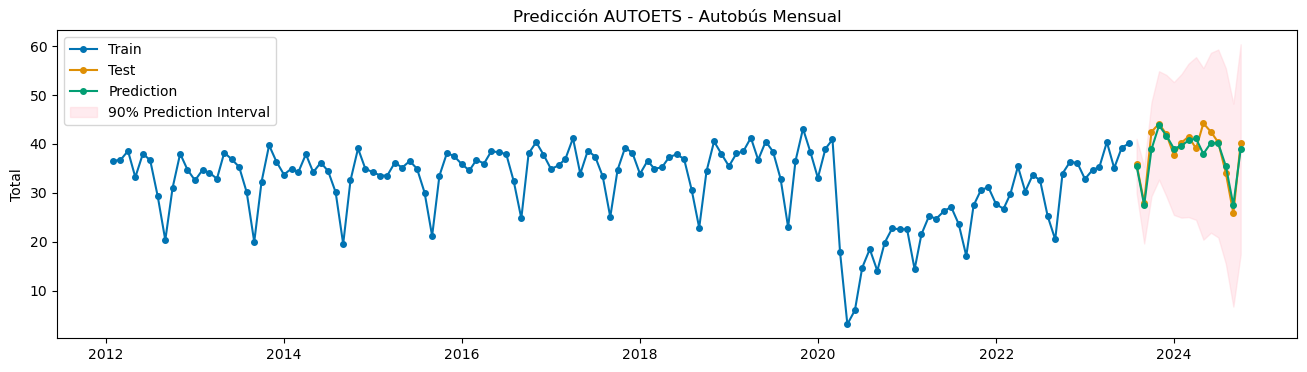

<Figure size 1400x700 with 0 Axes>

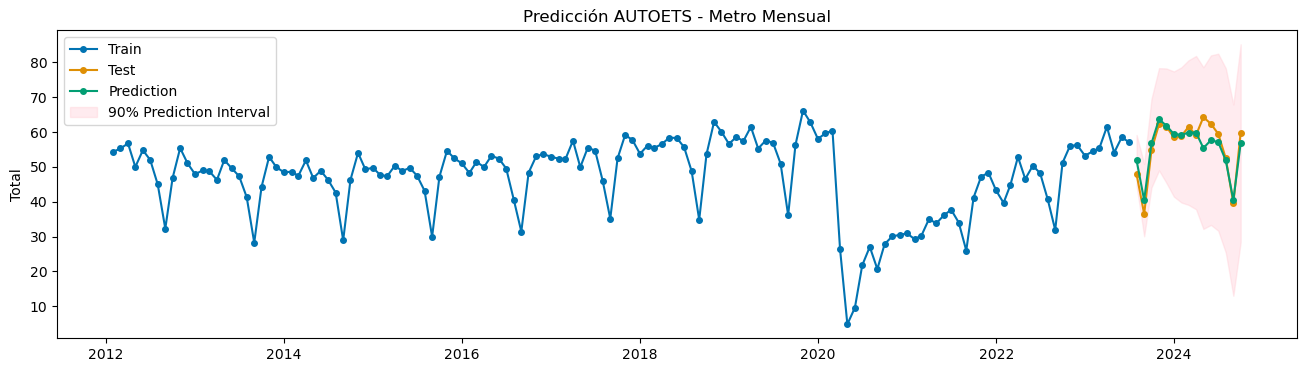

<Figure size 1400x700 with 0 Axes>

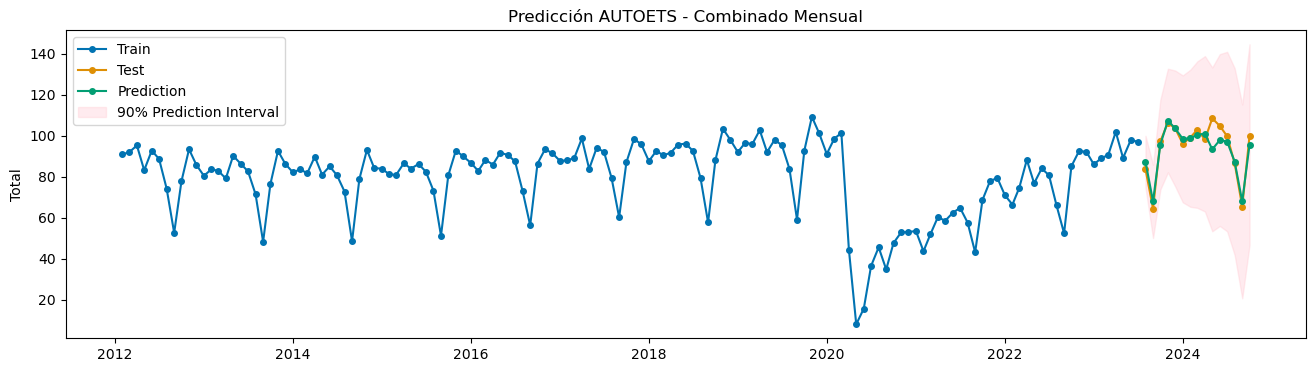

In [20]:
# Definir una función para realizar predicciones y graficar los resultados
def forecast_and_plot(series, title, sp, test_size):
    # Dividir los datos en entrenamiento y prueba
    y_train, y_test = temporal_train_test_split(series, test_size=test_size)
    
    # Definir el horizonte de predicción
    fh = ForecastingHorizon(y_test.index, is_relative=False)
    
    # Crear y ajustar el modelo AutoETS
    forecaster = AutoETS(auto=True, sp=sp, n_jobs=-1)
    forecaster.fit(y_train)
    
    # Realizar predicciones
    y_pred = forecaster.predict(fh)
    
    # Obtener el intervalo de confianza al 90%
    y_pred_int = forecaster.predict_interval(fh, coverage=0.90)
    
    # Asegurarse de que las columnas 'lower' y 'upper' existan
    if 'lower' not in y_pred_int.columns or 'upper' not in y_pred_int.columns:
        y_pred_int.columns = ['lower', 'upper']
    
    # Graficar los resultados
    plt.figure(figsize=(14, 7))
    plot_series(y_train, y_test, y_pred, labels=["Train", "Test", "Prediction"])
    plt.fill_between(y_pred_int.index, y_pred_int["lower"], y_pred_int["upper"], color='pink', alpha=0.3, label="90% Prediction Interval")
    plt.title(title)
    plt.legend()
    plt.show()

# Realizar predicciones y graficar para cada dataframe mensual con sp=12 y test_size=15
forecast_and_plot(df_autobus_month, "Predicción AUTOETS - Autobús Mensual", sp=12, test_size=15)
forecast_and_plot(df_metro_month, "Predicción AUTOETS - Metro Mensual", sp=12, test_size=15)
forecast_and_plot(df_combined_month, "Predicción AUTOETS - Combinado Mensual", sp=12, test_size=15)

Visualmente las predicciones mensuales se ajustan muy bien a la muestra de test, algo mejor que los modelos ARIMA y SARIMA, lo comprobaremos con las métricas de evaluación.

In [21]:
# Definir una función para realizar predicciones y calcular métricas
def forecast_and_calculate_metrics(series, sp, test_size):
    # Dividir los datos en entrenamiento y prueba
    y_train, y_test = temporal_train_test_split(series, test_size=test_size)
    
    # Definir el horizonte de predicción
    fh = ForecastingHorizon(y_test.index, is_relative=False)
    
    # Crear y ajustar el modelo AutoETS
    forecaster = AutoETS(auto=True, sp=sp, n_jobs=-1)
    forecaster.fit(y_train)
    
    # Realizar predicciones
    y_pred = forecaster.predict(fh)
    
    # Calcular métricas
    mse = MeanSquaredError()(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    
    return mse, rmse, mape

# Calcular métricas para cada dataframe mensual
mse_autobus_month, rmse_autobus_month, mape_autobus_month = forecast_and_calculate_metrics(df_autobus_month, sp=12, test_size=15)
mse_metro_month, rmse_metro_month, mape_metro_month = forecast_and_calculate_metrics(df_metro_month, sp=12, test_size=15) 
mse_combined_month, rmse_combined_month, mape_combined_month = forecast_and_calculate_metrics(df_combined_month, sp=12, test_size=15)

# Mostrar resultados
print("Métricas para Autobús Mensual:")
print(f"MSE: {mse_autobus_month}, RMSE: {rmse_autobus_month}, MAPE: {mape_autobus_month}")

print("\nMétricas para Metro Mensual:")
print(f"MSE: {mse_metro_month}, RMSE: {rmse_metro_month}, MAPE: {mape_metro_month}")

print("\nMétricas para Combinado Mensual:")
print(f"MSE: {mse_combined_month}, RMSE: {rmse_combined_month}, MAPE: {mape_combined_month}")


Métricas para Autobús Mensual:
MSE: 4.718598852179303, RMSE: 2.1722336090253513, MAPE: 0.038964134894091666

Métricas para Metro Mensual:
MSE: 10.574237900366414, RMSE: 3.251805329408022, MAPE: 0.04355536794726542

Métricas para Combinado Mensual:
MSE: 23.827076473422597, RMSE: 4.881298646202934, MAPE: 0.03511846408082429


Las tres series presentan unas mejores métricas de predicción, el MAPE apenas sube al 4.35% en la serie temporal mensual del metro. Por ahora, son los modelos que mejor se ajustan a los datos y captan la tendencia y la estacionalidad de los mismos.

<Figure size 1400x700 with 0 Axes>

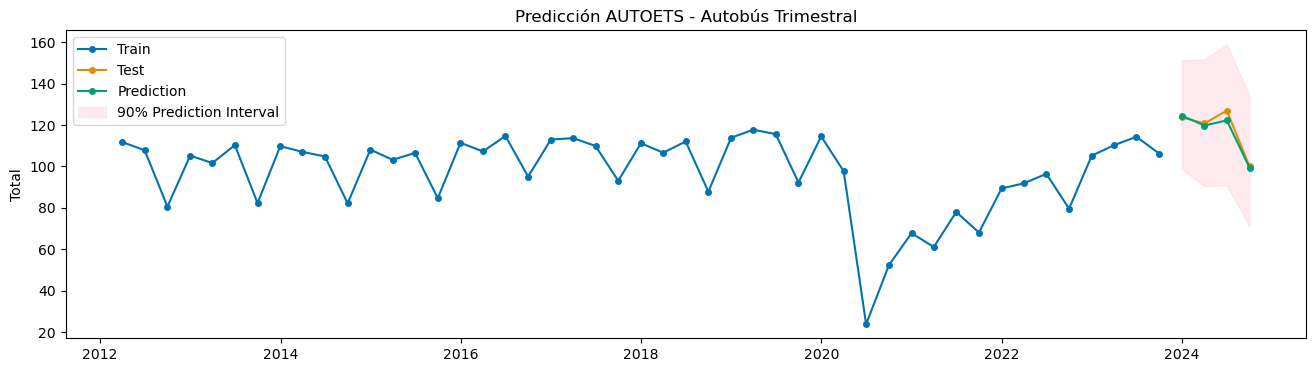

<Figure size 1400x700 with 0 Axes>

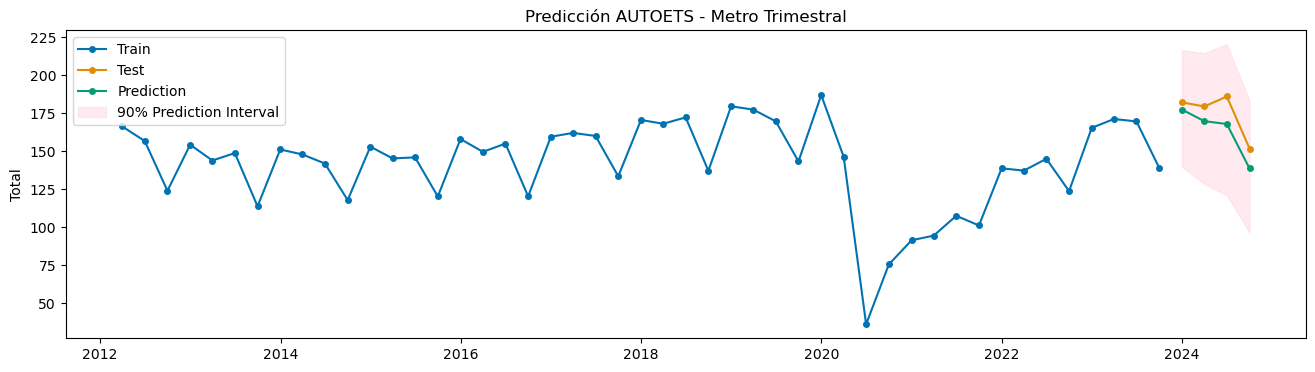

<Figure size 1400x700 with 0 Axes>

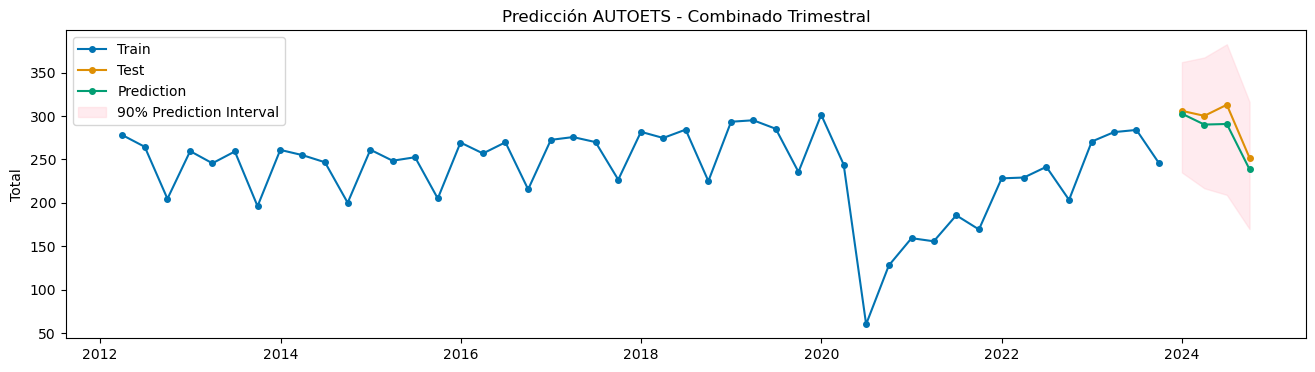

In [22]:
# Realizar predicciones y graficar para cada dataframe trimestral con sp=4 y test_size=8
forecast_and_plot(df_autobus_trim, "Predicción AUTOETS - Autobús Trimestral", sp=4, test_size=4)
forecast_and_plot(df_metro_trim, "Predicción AUTOETS - Metro Trimestral", sp=4, test_size=4)
forecast_and_plot(df_combined_trim, "Predicción AUTOETS - Combinado Trimestral", sp=4, test_size=4)

De manera trimestral, la predicción de los pasajeros de autobús parece muy buena, mientras que la del metro y combinado no tanto, aunque no malas. Evaluaremos las métricas.

In [25]:
# Calcular métricas para cada dataframe trimestral
mse_autobus_trim, rmse_autobus_trim, mape_autobus_trim = forecast_and_calculate_metrics(df_autobus_trim, sp=4, test_size=4)
mse_metro_trim, rmse_metro_trim, mape_metro_trim = forecast_and_calculate_metrics(df_metro_trim, sp=4, test_size=4)
mse_combined_trim, rmse_combined_trim, mape_combined_trim = forecast_and_calculate_metrics(df_combined_trim, sp=4, test_size=4)
# Mostrar resultados
print("Métricas para Autobús Trimestral:")
print(f"MSE: {mse_autobus_trim}, RMSE: {rmse_autobus_trim}, MAPE: {mape_autobus_trim}")

print("\nMétricas para Metro Trimestral:")
print(f"MSE: {mse_metro_trim}, RMSE: {rmse_metro_trim}, MAPE: {mape_metro_trim}")

print("\nMétricas para Combinado Trimestral:")
print(f"MSE: {mse_combined_trim}, RMSE: {rmse_combined_trim}, MAPE: {mape_combined_trim}")


Métricas para Autobús Trimestral:
MSE: 6.041031249196908, RMSE: 2.4578509412079708, MAPE: 0.014211584720710659

Métricas para Metro Trimestral:
MSE: 153.83868163959468, RMSE: 12.40317224098717, MAPE: 0.06590390395338475

Métricas para Combinado Trimestral:
MSE: 194.2642574724126, RMSE: 13.937871339354967, MAPE: 0.041847361695736864


La predicción trimestral de pasajeros de autobús es la mejor hasta la que hemos realizado, con un MAPE del 1.42% y un MSE de 6.04 puntos. Por ahora, los modelos ETS son los candidatos a realizar las predicciones finales de la serie temporal. En los siguientes notebooks veremos predicciones con modelos Bats, Theta, CES y modelos de machine learning como Prophet o Causal Impact.

*** 
## Conclusión ETS

Las métricas obtenidas para los modelos ETS muestran claras ventajas en comparación con los modelos ARIMA previamente utilizados. En particular, los modelos mensuales, especialmente el de autobús, presentan un rendimiento notable con valores bajos de MSE, RMSE y MAPE, lo que indica predicciones más precisas y con un menor margen de error. Este resultado subraya la efectividad de los modelos ETS para captar patrones de corto plazo, como tendencias y estacionalidades, de manera más eficiente que ARIMA en este caso. Aunque los modelos trimestrales tienen un rendimiento algo más variable, en general, los modelos ETS siguen ofreciendo mejores resultados que ARIMA, sobre todo en periodos más cortos. Esto resalta las ventajas de ETS frente a ARIMA, ya que, al ser más simples y adaptarse mejor a cambios en los datos, permiten obtener predicciones más exactas y confiables, especialmente cuando la serie temporal tiene una fuerte estacionalidad o tendencia.